In [1]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
from IPython.display import clear_output
clear_output()

In [4]:
load_dotenv()

# Initialize Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
)

In [5]:
classification_prompt = """
Classify the following input image into one of the following categories: [Affenpinscher, Afghan Hound, African Hunting Dog, Airedale, American Staffordshire Terrier, Appenzeller, Australian Terrier, Basenji, Basset, Beagle, Bedlington Terrier, Bernese Mountain Dog, Black-And-Tan Coonhound, Blenheim Spaniel, Bloodhound, Bluetick, Border Collie, Border Terrier, Borzoi, Boston Bull, Bouvier Des Flandres, Boxer, Brabancon Griffon, Briard, Brittany Spaniel, Bull Mastiff, Cairn, Cardigan, Chesapeake Bay Retriever, Chihuahua, Chow, Clumber, Cocker Spaniel, Collie, Curly-Coated Retriever, Dandie Dinmont, Dhole, Dingo, Doberman, English Foxhound, English Setter, English Springer, Entlebucher, Eskimo Dog, Flat-Coated Retriever, French Bulldog, German Shepherd, German Short-Haired Pointer, Giant Schnauzer, Golden Retriever, Gordon Setter, Great Dane, Great Pyrenees, Greater Swiss Mountain Dog, Groenendael, Ibizan Hound, Irish Setter, Irish Terrier, Irish Water Spaniel, Irish Wolfhound, Italian Greyhound, Japanese Spaniel, Keeshond, Kelpie, Kerry Blue Terrier, Komondor, Kuvasz, Labrador Retriever, Lakeland Terrier, Leonberg, Lhasa, Malamute, Malinois, Maltese Dog, Mexican Hairless, Miniature Pinscher, Miniature Poodle, Miniature Schnauzer, Newfoundland, Norfolk Terrier, Norwegian Elkhound, Norwich Terrier, Old English Sheepdog, Otterhound, Papillon, Pekinese, Pembroke, Pomeranian, Pug, Redbone, Rhodesian Ridgeback, Rottweiler, Saint Bernard, Saluki, Samoyed, Schipperke, Scotch Terrier, Scottish Deerhound, Sealyham Terrier, Shetland Sheepdog, Shih-Tzu, Siberian Husky, Silky Terrier, Soft-Coated Wheaten Terrier, Staffordshire Bullterrier, Standard Poodle, Standard Schnauzer, Sussex Spaniel, Tibetan Mastiff, Tibetan Terrier, Toy Poodle, Toy Terrier, Vizsla, Walker Hound, Weimaraner, Welsh Springer Spaniel, West Highland White Terrier, Whippet, Wire-Haired Fox Terrier, Yorkshire Terrier].
"""

In [6]:
# Recreate test_df (id, breed, img_b64) exactly as in the base notebook
from pathlib import Path
import pandas as pd
import base64

# 1. Locate dataset
root_dir = Path("stanford_dogs_dataset") / "images" / "Images"
if not root_dir.exists():
    raise FileNotFoundError(f"Expected dataset at {root_dir}. Run the download/unzip steps in the base notebook first.")

# 2. Build initial dataframe of all images (label = original folder name)
data = []
for d in root_dir.iterdir():
    if not d.is_dir():
        continue
    for p in d.iterdir():
        if p.suffix.lower() in {".jpg", ".jpeg", ".png"} and p.is_file():
            data.append({"label": d.name, "img_path": p})

dataset_df = pd.DataFrame(data)

# 3. Clean breed names (mirror logic from base notebook)
dataset_df["breed"] = (
    dataset_df["label"]
    .str.split("-", n=1).str[1]            # part after first '-'
    .str.replace("_", " ", regex=False)    # underscores to spaces
    .str.title()                            # title case
)

# 4. Keep first 50 images per breed (deterministic, no shuffling)
N_PER_BREED = 50
dataset_trimmed = (
    dataset_df
    .sort_values(["breed", "img_path"])   # ensures reproducibility
    .groupby("breed", as_index=False)
    .head(N_PER_BREED)
    .reset_index(drop=True)
)

# 5. Split 40/5/5 per breed → train/val/test
def assign_split(idx: int) -> str:
    if idx < 40:
        return "train"
    elif idx < 45:
        return "val"
    return "test"

dataset_trimmed["split"] = (
    dataset_trimmed
    .groupby("breed")
    .cumcount()
    .apply(assign_split)
)

# 6. Base64 encode (prefix with data URI) — same as base notebook
def path_to_b64(img_path: str | Path) -> str:
    with open(img_path, "rb") as fp:
        return base64.b64encode(fp.read()).decode()

dataset_trimmed["img_b64"] = "data:image/jpeg;base64," + dataset_trimmed["img_path"].apply(path_to_b64)

# 7. Helper to build split df (id, breed, img_b64)
def build_split_df(split_name: str) -> pd.DataFrame:
    return (
        dataset_trimmed.loc[dataset_trimmed["split"] == split_name, ["breed", "img_b64"]]
        .reset_index(drop=True)
        .rename_axis("id")
        .reset_index()
    )

# Create the three splits (only test_df needed here, but others are handy)
train_df = build_split_df("train")
val_df   = build_split_df("val")
test_df  = build_split_df("test")

print(f"Recreated splits: train={len(train_df)}, val={len(val_df)}, test={len(test_df)} (total {len(dataset_trimmed)})")
print("test_df columns:", list(test_df.columns))
print(test_df.head(2))

Recreated splits: train=4800, val=600, test=600 (total 6000)
test_df columns: ['id', 'breed', 'img_b64']
   id          breed                                            img_b64
0   0  Affenpinscher  data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...
1   1  Affenpinscher  data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...


In [7]:
test_df

,id,breed,img_b64
0,0,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
1,1,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
2,2,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
3,3,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
4,4,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
...,...,...,...
595,595,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
596,596,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
597,597,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
598,598,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."


In [8]:
import time, statistics, math, os, json
from typing import List, Dict, Any
from dataclasses import dataclass
import pandas as pd

# Ensure test_df exists
try:
    test_df  # noqa
except NameError:
    raise NameError("test_df not found. Re-run the cell that reconstructs the dataset.")

BASE_DEPLOYMENT = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
FT_DEPLOYMENT   = os.getenv("AZURE_OPENAI_FT_DEPLOYMENT_NAME") or "gpt-4o-2024-08-06-ft"

if not BASE_DEPLOYMENT:
    raise EnvironmentError("AZURE_OPENAI_DEPLOYMENT_NAME env var not set.")

models_to_test = [
    {"name": "base", "deployment": BASE_DEPLOYMENT, "prompt": classification_prompt},
]
if FT_DEPLOYMENT:
    models_to_test.append({"name": "fine_tuned", "deployment": FT_DEPLOYMENT, "prompt": classification_prompt})

MAX_RETRIES = 3
BACKOFF_SEC = 2.0

@dataclass
class TimingResult:
    model: str
    deployment: str
    id: int
    breed: str
    latency_ms: float
    error: str | None

results: List[TimingResult] = []

for model_cfg in models_to_test:
    name = model_cfg["name"]
    deployment = model_cfg["deployment"]
    prompt_txt = model_cfg["prompt"]
    print(f"\n=== Measuring latency for {name} ({deployment}) ===")
    model_start_wall = time.perf_counter()

    for _, row in test_df.iterrows():
        img_b64 = row["img_b64"]
        sample_id = int(row["id"]) if not math.isnan(row["id"]) else row["id"]
        breed = row["breed"]

        attempt = 0
        last_error = None
        while attempt < MAX_RETRIES:
            attempt += 1
            start = time.perf_counter()
            try:
                response = client.chat.completions.create(
                    model=deployment,
                    messages=[
                        {"role": "system", "content": prompt_txt},
                        {"role": "user", "content": [
                            {"type": "image_url", "image_url": {"url": img_b64, "detail": "low"}}
                        ]},
                    ],
                    max_tokens=10,
                    temperature=0,
                    seed=42,
                )
                end = time.perf_counter()
                latency_ms = (end - start) * 1000.0
                results.append(TimingResult(name, deployment, sample_id, breed, latency_ms, None))
                break
            except Exception as e:  # noqa
                end = time.perf_counter()
                latency_ms = (end - start) * 1000.0
                last_error = str(e)
                print(f"[WARN] {name} id={sample_id} attempt={attempt} failed: {e}")
                if attempt < MAX_RETRIES:
                    time.sleep(BACKOFF_SEC * attempt)
                else:
                    results.append(TimingResult(name, deployment, sample_id, breed, latency_ms, last_error))

    model_elapsed = time.perf_counter() - model_start_wall
    print(f"Completed {name} model in {model_elapsed:.2f}s")

# Aggregate metrics
if not results:
    raise RuntimeError("No latency results collected.")

rows = [r.__dict__ for r in results]
latency_df = pd.DataFrame(rows)

summary_rows: List[Dict[str, Any]] = []
for model_name, grp in latency_df.groupby("model"):
    latencies = list(grp[grp["error"].isna()]["latency_ms"])  # successes only for distribution
    total = len(grp)
    successes = len(latencies)
    errors = total - successes
    if successes:
        latencies_sorted = sorted(latencies)
        def pct(p):
            if not latencies_sorted:
                return math.nan
            k = (len(latencies_sorted)-1) * p
            f = math.floor(k)
            c = math.ceil(k)
            if f == c:
                return latencies_sorted[int(k)]
            return latencies_sorted[f] + (latencies_sorted[c]-latencies_sorted[f]) * (k-f)
        mean = statistics.fmean(latencies_sorted)
        median = statistics.median(latencies_sorted)
        p50 = pct(0.50)
        p90 = pct(0.90)
        p95 = pct(0.95)
        p99 = pct(0.99)
        std_dev = statistics.pstdev(latencies_sorted) if successes > 1 else 0.0
        min_v = latencies_sorted[0]
        max_v = latencies_sorted[-1]
    else:
        mean = median = p50 = p90 = p95 = p99 = std_dev = min_v = max_v = math.nan

    wall_time = (
        latency_df[latency_df["model"] == model_name]["latency_ms"].sum() / 1000.0  # crude additive (excludes wait on retries)    
    )
    throughput = successes / wall_time if wall_time > 0 else math.nan

    summary_rows.append({
        "model": model_name,
        "deployment": grp["deployment"].iloc[0],
        "total_requests": total,
        "success_count": successes,
        "error_count": errors,
        "mean_ms": round(mean, 2),
        "median_ms": round(median, 2),
        "p50_ms": round(p50, 2),
        "p90_ms": round(p90, 2),
        "p95_ms": round(p95, 2),
        "p99_ms": round(p99, 2),
        "min_ms": round(min_v, 2),
        "max_ms": round(max_v, 2),
        "std_dev_ms": round(std_dev, 2),
        "throughput_rps_est": round(throughput, 3),
    })

latency_summary_df = pd.DataFrame(summary_rows)
print("Latency summary (ms):")
latency_summary_df


=== Measuring latency for base (gpt-4o) ===
[WARN] base id=411 attempt=1 failed: Extra data: line 2 column 10 (char 10)
[WARN] base id=411 attempt=1 failed: Extra data: line 2 column 10 (char 10)
Completed base model in 1002.76s

=== Measuring latency for fine_tuned (gpt-4o-2024-08-06-ft) ===
Completed base model in 1002.76s

=== Measuring latency for fine_tuned (gpt-4o-2024-08-06-ft) ===
Completed fine_tuned model in 903.76s
Latency summary (ms):
Completed fine_tuned model in 903.76s
Latency summary (ms):


,model,deployment,total_requests,success_count,error_count,mean_ms,median_ms,p50_ms,p90_ms,p95_ms,p99_ms,min_ms,max_ms,std_dev_ms,throughput_rps_est
0,base,gpt-4o,600,600,0,1665.08,1629.17,1629.17,1963.85,2182.58,2737.33,1053.66,4693.65,324.15,0.601
1,fine_tuned,gpt-4o-2024-08-06-ft,600,600,0,1505.97,1505.29,1505.29,1706.80,1819.48,2302.56,824.95,3381.80,241.33,0.664


## Latency Benchmark: Base vs Fine-Tuned Model
We measure per-image end-to-end latency for both deployments on the entire `test_df`.

Metrics collected per model:
- total_requests
- success_count / error_count
- mean_latency_ms
- median / p50 / p90 / p95 / p99 (ms)
- min / max (ms)
- requests_per_second (throughput over wall time)
- std_dev_ms

Timing phases captured (for potential further drill-down):
- end_to_end_ms: wall time from just before API call to first token reception (simple synchronous call)

Notes:
- Calls are sequential (single-threaded) to give a clean comparison.
- `detail` is set to `low` to keep image token cost consistent.
- Retries: simple linear backoff on transient errors (HTTP 429/5xx) up to 3 attempts.
- You can later parallelize (with care) if you want throughput measurements rather than pure per-request latency.

Run the next cell to execute the benchmark.

## Latency Visualizations
Below we plot:
- Histogram of per-request latencies (ms) per model
- Boxplot comparing latency distributions

Assumes `latency_df` already exists from the benchmark cell (only successful requests are shown).

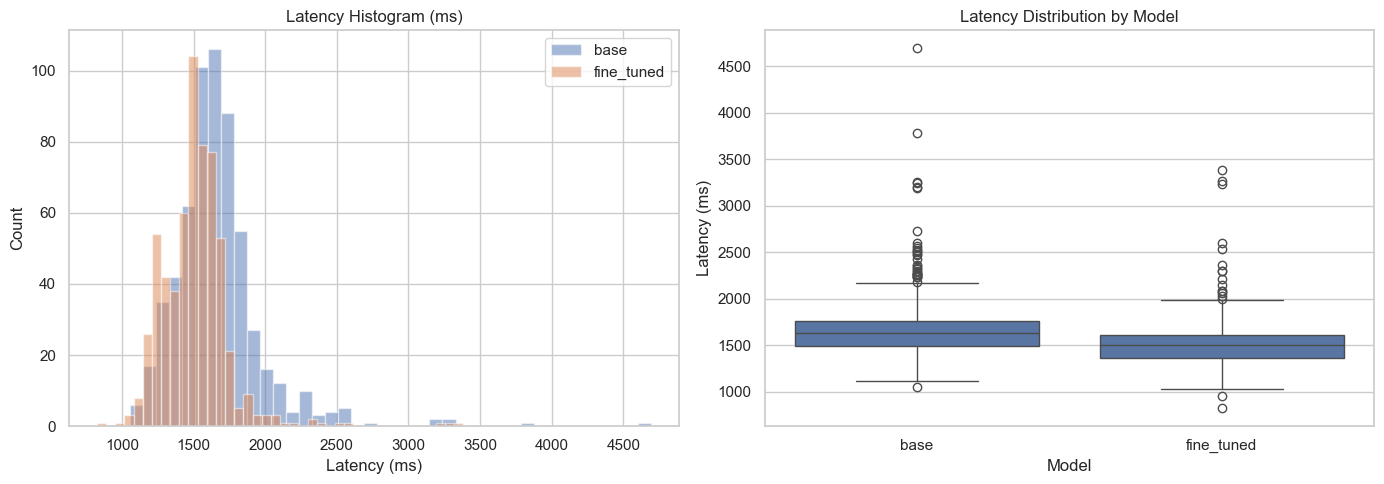

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preconditions
if 'latency_df' not in globals():
    raise NameError("latency_df not found. Run the main latency benchmark cell first.")

sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Histogram
for model_name, grp in latency_df.groupby('model'):
    axes[0].hist(grp[grp.error.isna()]['latency_ms'], bins=40, alpha=0.5, label=model_name)
axes[0].set_title('Latency Histogram (ms)')
axes[0].set_xlabel('Latency (ms)')
axes[0].set_ylabel('Count')
axes[0].legend()

# Boxplot
sns.boxplot(data=latency_df[latency_df.error.isna()], x='model', y='latency_ms', ax=axes[1])
axes[1].set_title('Latency Distribution by Model')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Latency (ms)')

plt.tight_layout()
plt.show()

### Save Latency Plots
The next cell regenerates and saves the latency histogram and boxplot to `public/latency_histogram.png` and `public/latency_boxplot.png` for inclusion in the README.

Saved histogram to public\latency_histogram.png
Saved boxplot to public\latency_boxplot.png


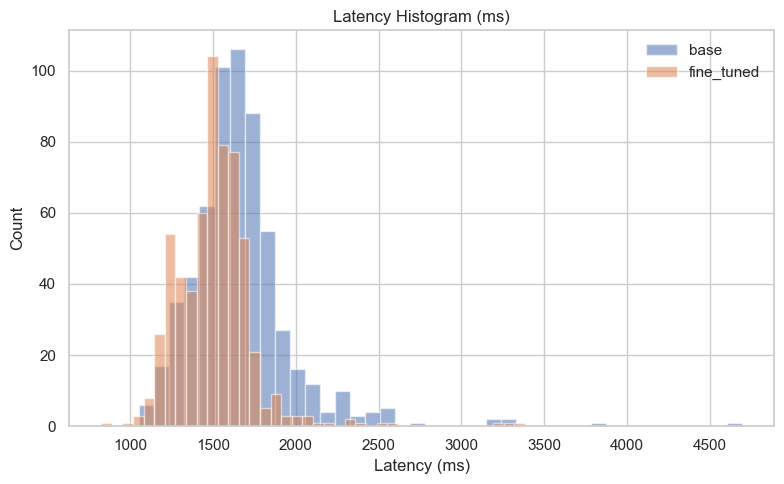

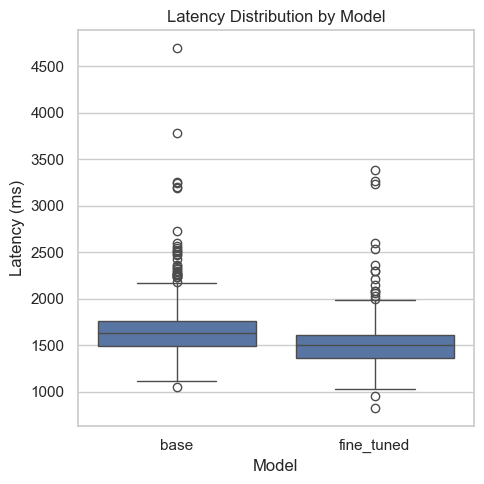

In [12]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

if 'latency_df' not in globals():
    raise NameError('latency_df not found. Run the latency benchmark first.')

out_dir = Path('public')
out_dir.mkdir(exist_ok=True)

hist_path = out_dir / 'latency_histogram.png'
box_path  = out_dir / 'latency_boxplot.png'

sns.set_theme(style='whitegrid')

# Histogram (successes only)
hist_fig, hist_ax = plt.subplots(figsize=(8,5))
for model_name, grp in latency_df.groupby('model'):
    hist_ax.hist(grp[grp.error.isna()]['latency_ms'], bins=40, alpha=0.55, label=model_name)
hist_ax.set_title('Latency Histogram (ms)')
hist_ax.set_xlabel('Latency (ms)')
hist_ax.set_ylabel('Count')
hist_ax.legend(frameon=False)
hist_fig.tight_layout()
hist_fig.savefig(hist_path, dpi=150)
print(f'Saved histogram to {hist_path}')

# Boxplot (successes only)
box_fig, box_ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=latency_df[latency_df.error.isna()], x='model', y='latency_ms', ax=box_ax)
box_ax.set_title('Latency Distribution by Model')
box_ax.set_xlabel('Model')
box_ax.set_ylabel('Latency (ms)')
box_fig.tight_layout()
box_fig.savefig(box_path, dpi=150)
print(f'Saved boxplot to {box_path}')

# (Optional) Display both inline
plt.show()
